# Car insurance claim dataset

#### Context

Your client is a car insurance company. They want to price their car insurance competitively, which means having a good model for customers at risk of getting into accidents.

#### Content

Each row corresponds to a customer, the outcome column records whether the customer made a claim in the previous year or not. The client has informed you that the other columns should be self-explanatory.

### Inspiration

The client is interested to know if the customer data can be used to predict the likelihood that a claim is made in the next
year. Your task is to investigate this and make a recommendation. You should complete the following tasks:

* Build a proof-of-concept model to predict the outcome column from the customer data, including any necessary data
processing
* The client is keen to be able to interpret the model you build and would be particularly interested in understanding
which features are most important to the model's decisions.

#### Dataset extracted from [Kaggle](https://www.kaggle.com/racholsan/customer-data?select=customer-data.csv)

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [40]:
df=pd.read_csv('customer-data.csv',index_col=0)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  object 
 1   gender               10000 non-null  object 
 2   race                 10000 non-null  object 
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  bool   
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  bool   
 10  children             10000 non-null  bool   
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  DUIs                 10000 non-null

In [42]:
df.head()

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome
id,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False
750365,16-25,male,majority,0-9y,none,poverty,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True
199901,16-25,female,majority,0-9y,high school,working class,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False
478866,16-25,male,majority,0-9y,university,working class,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False
731664,26-39,male,majority,10-19y,none,working class,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True


## behavior of our variable to predict with respect to the others

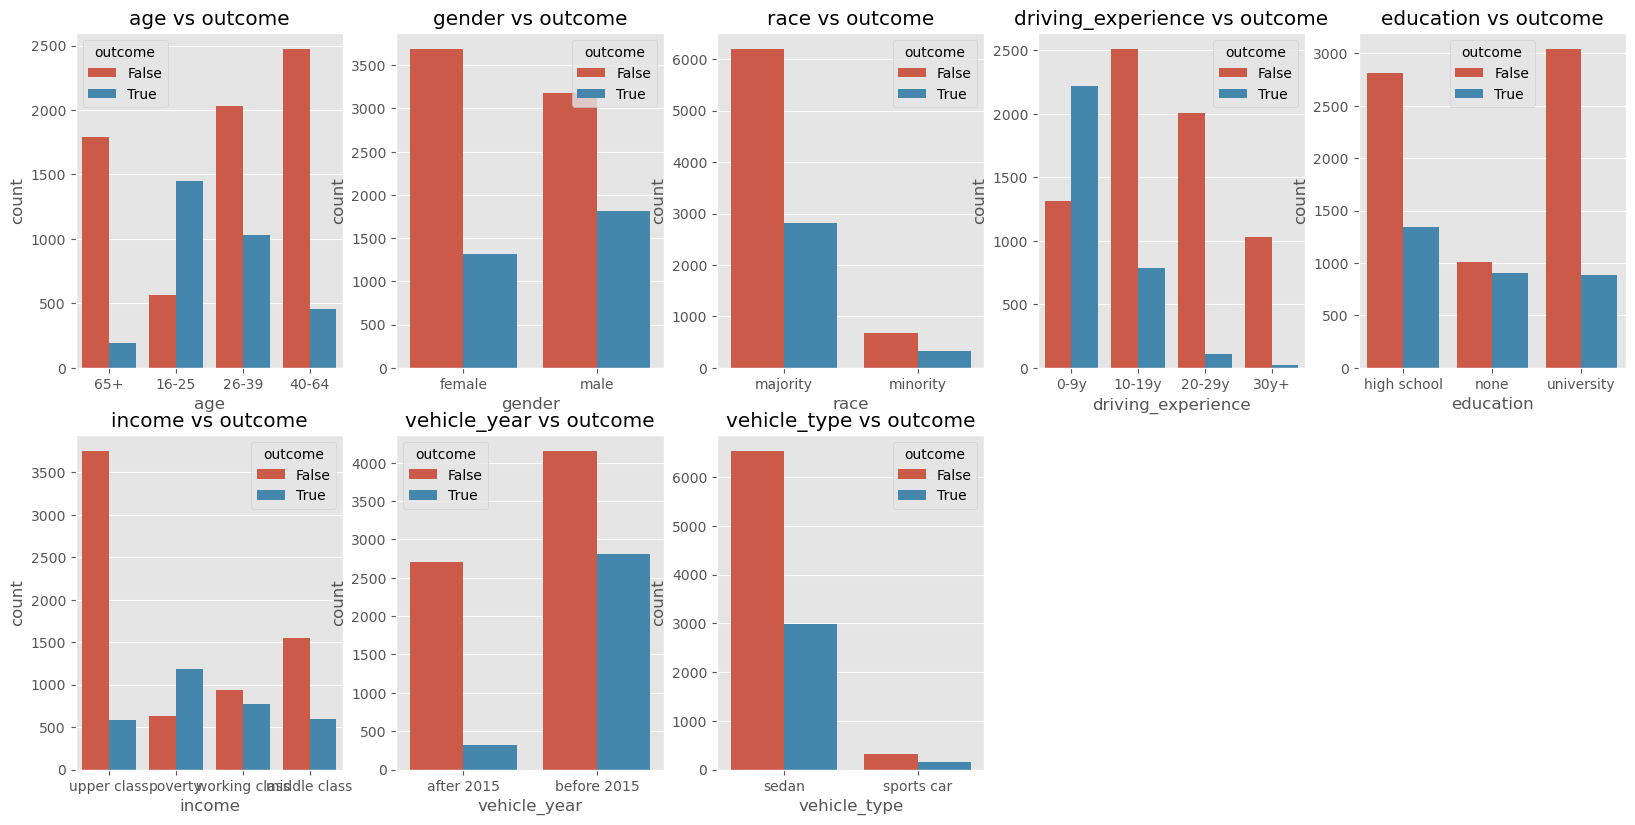

In [43]:
category=df.select_dtypes('object')
plt.figure(figsize=(20, 20))
for i in category:
    plt.subplot(4, 5, list(category.columns).index(i) + 1)
    sns.countplot(data=df,x=i,hue='outcome')
    plt.title(i+' vs outcome')

plt.show()

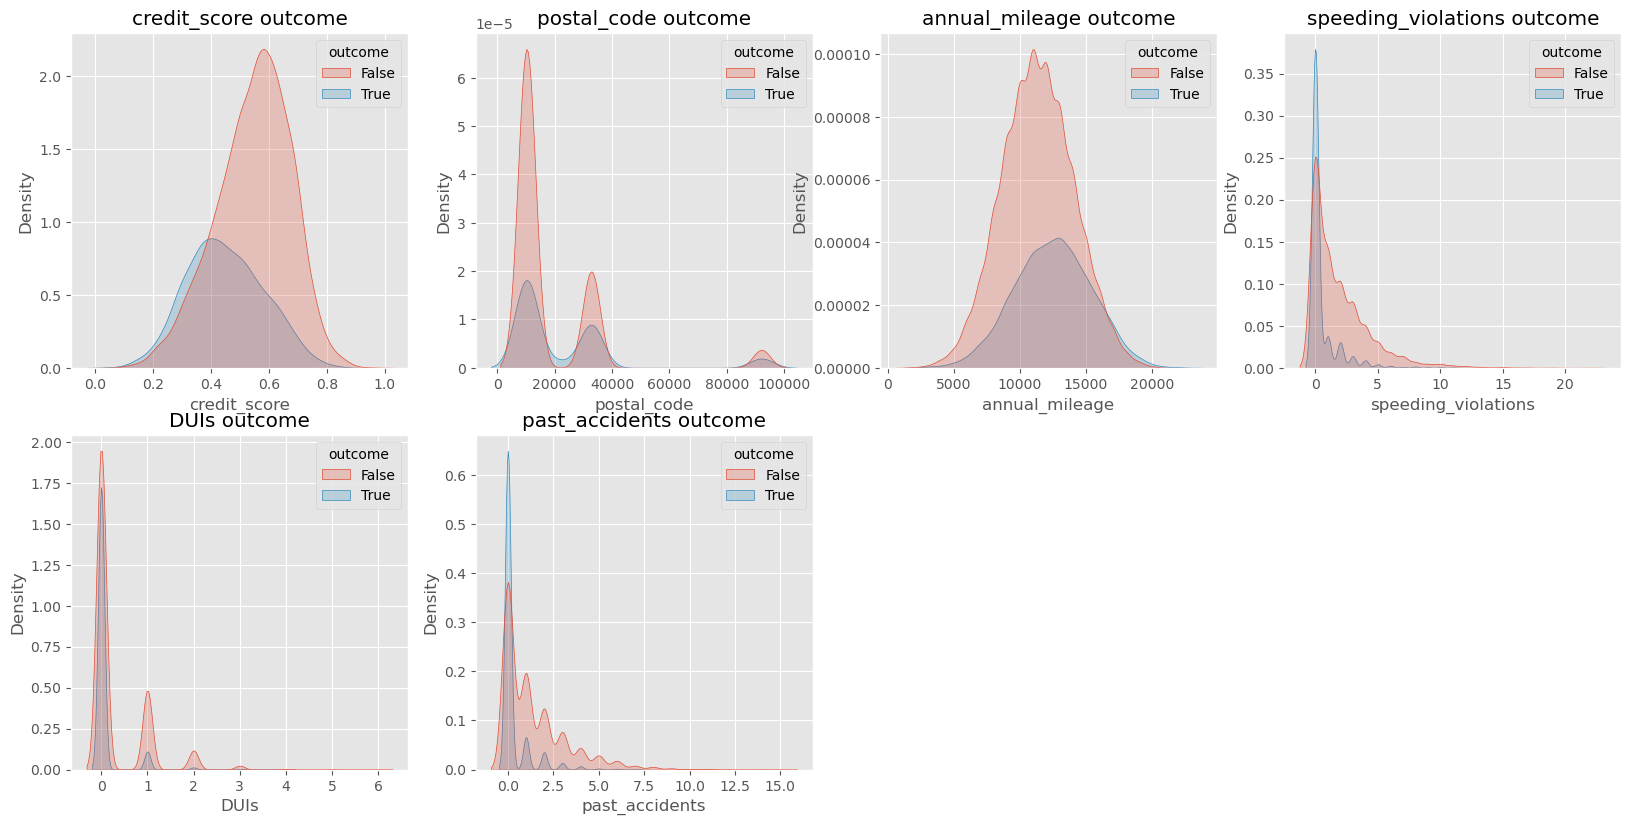

In [27]:
numbers=df.select_dtypes('number')
plt.figure(figsize=(20, 20))
for i in numbers:
    plt.subplot(4, 4, list(numbers.columns).index(i) + 1)
    sns.kdeplot(data=df,x=i,hue='outcome', fill=True)
    plt.title(i+' outcome')

plt.show()

In [46]:
#As we can see, all these categorical features can be converted in numbers as they have order, except
age_dic={'16-25':1,'26-39':2,'40-64':3,'65+':4}
driving_dic={'0-9y':1,'10-19y':2,'20-29y':3,'30y+':4}
education_dic={'none':1,'high school':1,'university':2}
income_dic={'poverty':1,'working class': 2,'middle class': 3,'upper class': 4}

df['age']=df['age'].map(lambda x:age_dic[x])
df['driving_experience']=df['driving_experience'].map(lambda x:driving_dic[x])
df['education']=df['education'].map(lambda x:education_dic[x])
df['income']=df['income'].map(lambda x:income_dic[x])

In [49]:
#the rest, since are binary features, will be converted in True or False
df=pd.get_dummies(df,drop_first=True)

# Missing Data

Text(0.5, 1.0, 'Missing Data')

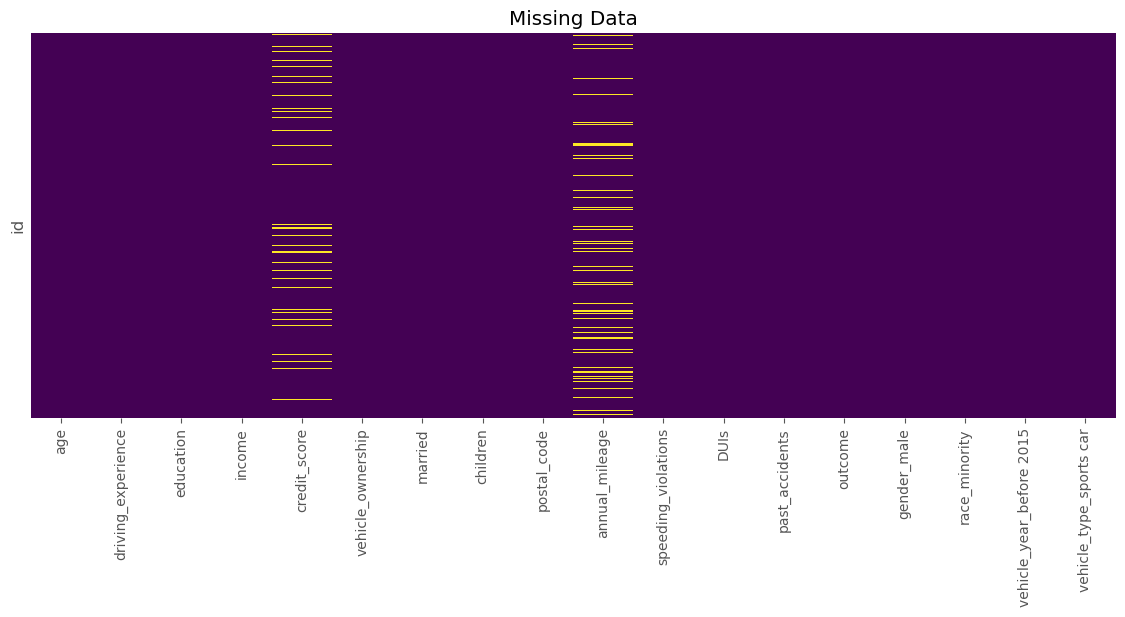

In [50]:
plt.figure(figsize=(14,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing Data')

E:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



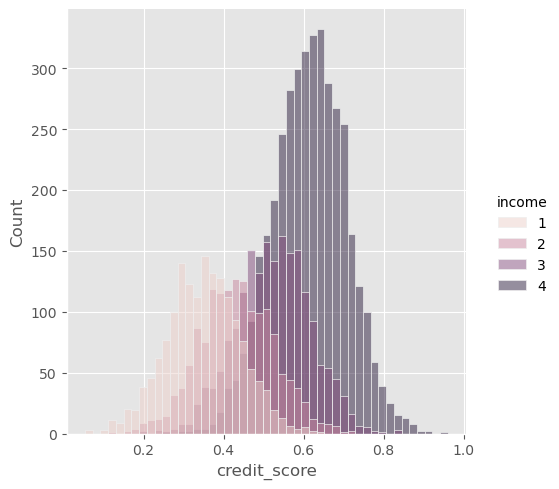

In [51]:
sns.displot(x='credit_score',data=df,hue='income')
#We can see, each income class has different credit score distribution

In [30]:
df.groupby('income')['credit_score'].describe()['mean'].reset_index()
#Here, we have the credit score mean value, grouping by the income class

,income,mean
0,middle class,0.523659
1,poverty,0.348331
2,upper class,0.613827
3,working class,0.431929


In [52]:
#filling in the missing data
def missing_score(x):
    score = x[0]
    income = x[1]
    
    if pd.isnull(score):

        if income==3:
            return 0.523659

        elif income==1:
            return 0.348331

        elif income==4:
            return 0.613827
        else:
            return 0.431929

    else:
        return score

In [53]:
df['credit_score']=df[['credit_score','income']].apply(missing_score,axis=1)

<Axes: ylabel='id'>

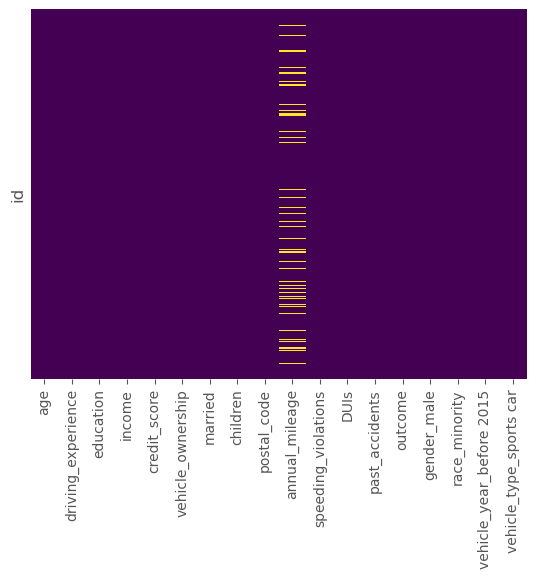

In [54]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [56]:
df.drop(['annual_mileage'],axis=1,inplace=True)

## Correlations

<Axes: >

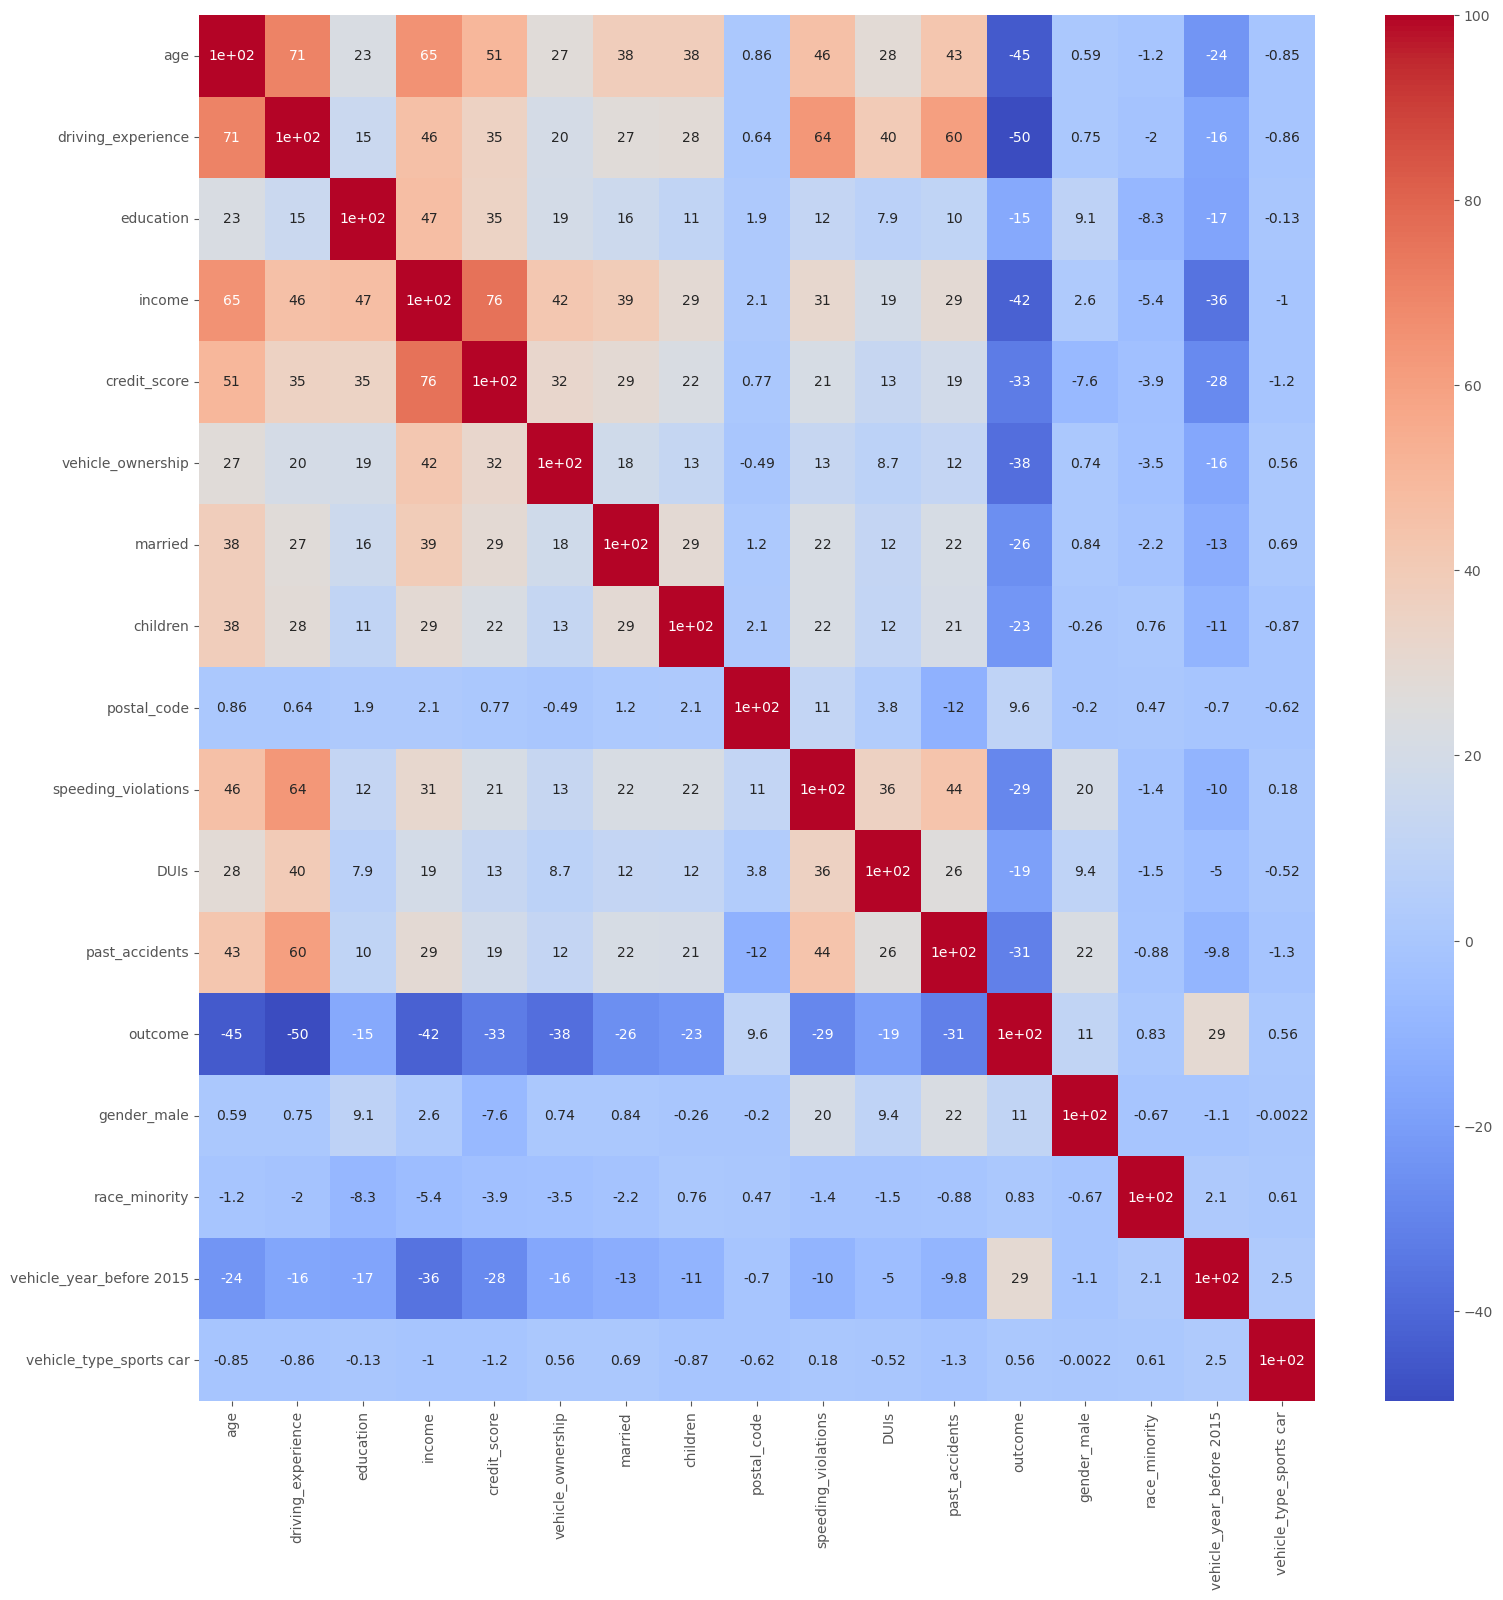

In [57]:
#correlations between all the features
plt.figure(figsize=(18,18))
sns.heatmap(data=df._get_numeric_data().corr()*100,annot=True,cmap='coolwarm')

<Axes: title={'center': 'Correlations between Outcome and all the features'}>

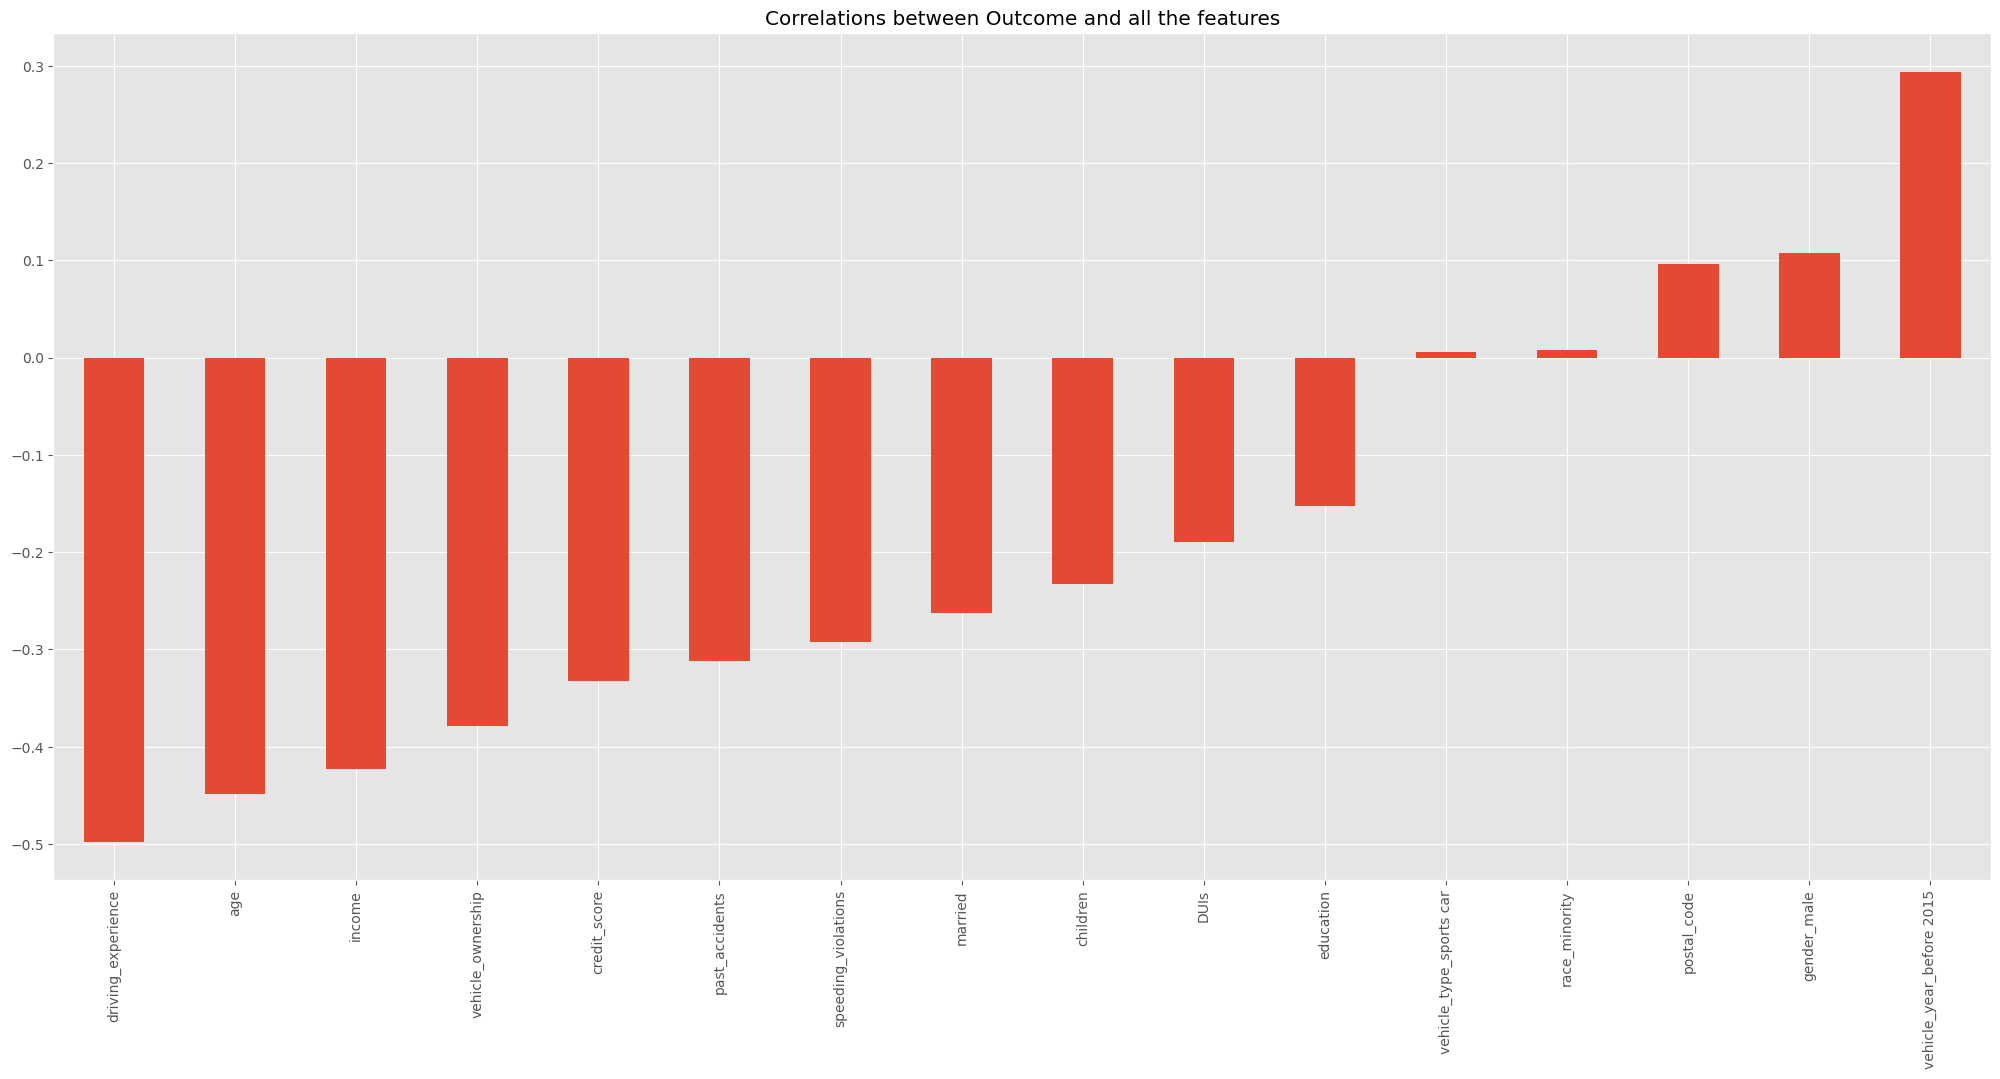

In [62]:
plt.figure(figsize=(25,11))
plt.title('Correlations between Outcome and all the features')
df.corr().sort_values(by='outcome')['outcome'].drop('outcome').plot.bar()

### Here we can clearly see, customers with greater driving experience, age, income, married, with children and with little accident history are less likely to use insurance, while men and vehicles older than 2015 are using insurance more

Let's just keep the 12 most correlated features

In [93]:
importat_features=abs(df.corr()).sort_values(by='outcome',ascending=False)['outcome'].drop('outcome')[0:10].index

## Let's create a machine learning project


In [71]:
from sklearn.model_selection import train_test_split

In [95]:
X=df[importat_features]
y=df['outcome']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
from sklearn.linear_model import LogisticRegression

In [99]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [100]:
predictions = logmodel.predict(X_test)

In [101]:
from sklearn.metrics import classification_report,confusion_matrix

In [102]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.86      0.87      0.87      2026
        True       0.73      0.71      0.72       974

    accuracy                           0.82      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.82      0.82      0.82      3000



We are obtaining a general accuracy of 82%, where if it is predicted that the client uses the insurance, there is a 73% probability that he will use it. Since we deal with insurance, it's a good prediction.